    -virtualenv "torch19cuda11"
    -cd torch19cuda11
    -torch19cuda11/bin/activate
    -pip install jupyter
    -ipython kernel install --name "local-venv" --user
    -pip install opencv-python


In [1]:
import sys
import traceback

In [2]:
# windows torch
# !{sys.executable} -m pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

# linux torch
#!{sys.executable} -m pip install torch torchvision torchaudio

# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install tqdm
# !{sys.executable} -m pip install albumentations
# !{sys.executable} -m pip install efficientnet_pytorch
# !{sys.executable} -m pip install neptune-client
# !{sys.executable} -m pip install python-dotenv
# !{sys.executable} -m pip install scikit-learn
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install imbalanced-learn
# !{sys.executable} -m pip install pandoc

In [3]:
from dotenv import dotenv_values
config = dotenv_values(".env")

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import cv2
import random
import copy
import pandas as pd
import albumentations as alb
from albumentations.pytorch import ToTensorV2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim 

import neptune.new as neptune

from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import imblearn

In [5]:
print(f'CUDA version: {torch.version.cuda}')
print(f'Torch version: {torch.__version__}')

CUDA version: 11.1
Torch version: 1.9.0+cu111


In [6]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 1060 with Max-Q Design
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [7]:
run = neptune.init(
    project=config['PROJECT'],
    api_token=config['API_TOKEN']
)

psutil is not installed. Hardware metrics will not be collected.


https://app.neptune.ai/inno/flowers/e/FLOW-15
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


### Для работы был выбран датасет Oxford 102 Flowers
### https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html


### Загрузка аннотаций

In [8]:
# Пути к данным
data_folder = 'jpg'
flowers_meta_fn = 'imagelabels.mat'
flowers_labels_fn = 'Oxford-102_Flower_dataset_labels.csv'

In [9]:
# Аннотации хранятся в mat-файле
flowers_annot_mat = scipy.io.loadmat(flowers_meta_fn)
flowers_annot_mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 '__globals__': [],
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}

#### Для удобства конвертируем mat в pandas Dataframe

In [10]:
# Функция конвертации (работает с конкретным mat-файлом)
def convert_to_df(mat_file):
    table_name = [k for k in mat_file.keys() if '__' not in k][0]
    dtypes = mat_file[table_name].dtype
    if len(dtypes) > 1:
        col_names = list(mat_file[table_name].dtype.names)
    else:
        col_names = ['class']
    table_size = len(mat_file[table_name][0])

    print(f'Table name: {table_name}')
    print(f'Column names: {col_names}')
    print(f'Table size: {table_size}')
    print()


    cleared_table = []
    for rec in range(table_size):
        record_data =  mat_file[table_name][0][rec]
        cleared_table.append(record_data)
    
    return pd.DataFrame(cleared_table, columns=col_names)

In [11]:
# Конвертация в dataframe
data_annot_df = convert_to_df(flowers_annot_mat)
data_annot_df['fname'] = data_annot_df.reset_index()['index'].apply(lambda x: f"image_{x+1:05}.jpg")

# Классы должны начинаться с 0 для модели
data_annot_df['class'] -= 1
data_annot_df.head()

Table name: labels
Column names: ['class']
Table size: 8189



,class,fname
0,76,image_00001.jpg
1,76,image_00002.jpg
2,76,image_00003.jpg
3,76,image_00004.jpg
4,76,image_00005.jpg


In [12]:
# Загружаем данные по названиям классов в датасете
label_mapping = pd.read_csv(flowers_labels_fn)
label_mapping.head(5)

,label
0,'pink primrose'
1,'hard-leaved pocket orchid'
2,'canterbury bells'
3,'sweet pea'
4,'english marigold'


### Разбивка данных

In [13]:
# Разбиваем на обучающую и тестовую выборку
train_data, test_data= train_test_split(
    data_annot_df,
    test_size=0.3,
    stratify=data_annot_df['class'].values,
    random_state=42
)

# Дополнительно выделяем из тестовой валидирующую, которую будетм использовать для 
# контроля над переобучением модели
val_data, test_data= train_test_split(
    test_data,
    test_size=0.2,
    stratify=test_data['class'].values,
    random_state=42
)
print(f'Train data size: {len(train_data)}')
print(f'Val data size: {len(val_data)}')
print(f'Test data size: {len(test_data)}')

Train data size: 5732
Val data size: 1965
Test data size: 492


### Балансировка обучающей выборки

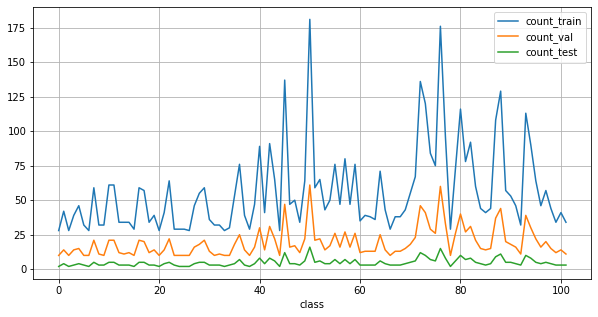

In [14]:
fig, ax = plt.subplots(figsize=(10,5)) 

agg_count_train = train_data.groupby('class').agg(count_train=('class', 'count'))
agg_count_val = val_data.groupby('class').agg(count_val=('class', 'count'))
agg_count_test = test_data.groupby('class').agg(count_test=('class', 'count'))
agg_count_train.plot(ax=ax)
agg_count_val.plot(ax=ax)
agg_count_test.plot(ax=ax)
ax.grid()

In [15]:
# Увеличиваем кол-во данных по миноритарным классам для более равномерного обучения модели
mean_count = int(agg_count_train['count_train'].mean())
ros = imblearn.over_sampling.RandomOverSampler(
    random_state=42,
#     sampling_strategy={
#         cls:mean_count for cls in data_annot_df['class'].values if agg_count['count'][cls] < mean_count
#     },
    sampling_strategy='not majority'

)
train_data, _ = ros.fit_resample(train_data, list(train_data['class'].values))

# shuffle data for uniform training
train_data = train_data.sample(frac=1, random_state=42)
train_data.head()

,class,fname
2608,45,image_01052.jpg
273,87,image_00569.jpg
1346,29,image_03504.jpg
12160,47,image_04666.jpg
3780,28,image_04095.jpg


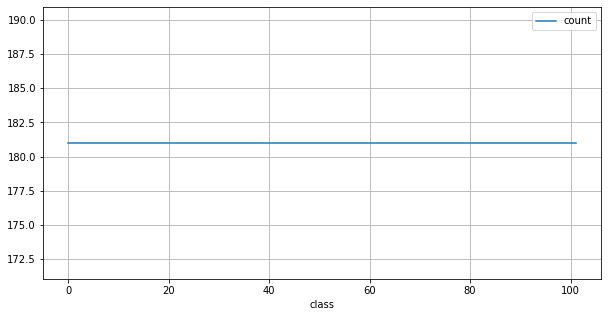

In [16]:
# Кол-во вхождений классов в датасет должно быть равномерным
fig, ax = plt.subplots(figsize=(10,5)) 

train_data.groupby('class').agg(count=('class', 'count')).plot(ax=ax)
ax.grid()

### Функция визуализации изображений и лейблов

In [17]:
def display_image_grid(images_filepaths, 
                       true_labels, 
                       predicted_labels=None,
                       label_mapping = None,
                       cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = true_labels[i]
        predicted_label = predicted_labels[i] if predicted_labels is not None else true_label
        
        color = "green" if true_label == predicted_label else "red"
        
        if label_mapping is not None:
            predicted_label = label_mapping['label'][predicted_label]

        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    return figure

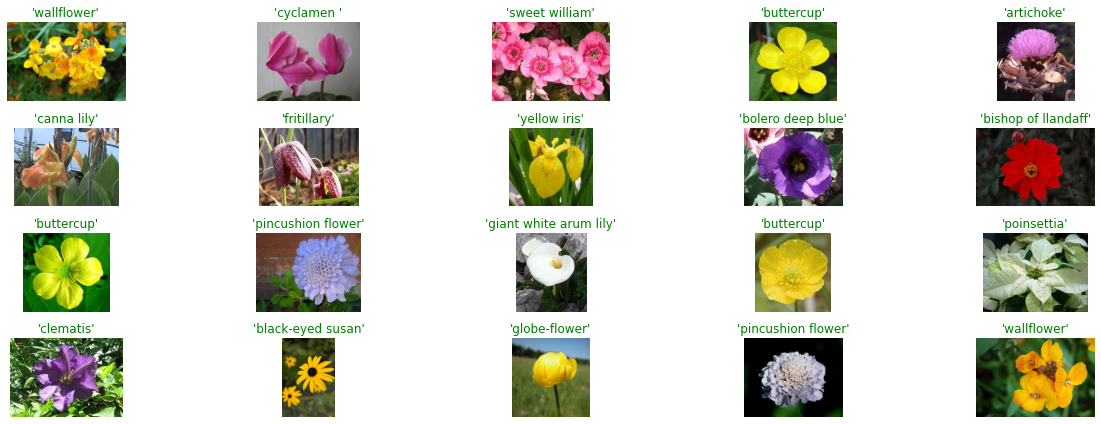

In [18]:
# Пример данных из датасета с названиями
data_to_display = train_data.head(20)
figure = display_image_grid(
    [os.path.join(data_folder, fn) for fn in data_to_display['fname'].values],
    true_labels=data_to_display['class'].values,
    label_mapping = label_mapping
)

# run['images-examples'].upload(figure)

In [19]:
# Создание датасета
# Данный класс позволит использовать датасет в модели для pytorch
# по запросу подгружая данные, что снижает необходимый объем оперативной памяти
class FlowersDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        super().__init__()
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name = self.df['fname'].values[index]
        label = None
        if 'class' in self.df.columns:
            label = torch.tensor(self.df['class'].values[index], dtype=torch.long)
        img_path = os.path.join(self.data_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image=image)["image"]
            
        return image, label

# Подготовка датасета

In [20]:
# Словарь с параметрами работы модели
input_size = {
    'efficientnet-b0':224,
    'efficientnet-b1':240,
    'efficientnet-b2':260,
    
}

params = dict(
    device='cuda',
    model='efficientnet-b1',
    test_size=200,
    batch_size=16,
    eval_batch_size=16,
    num_workers=0,
    pin_memory=True,
    epochs=5,
    optimizer='adam',
    criterion='crossentropyloss',
    use_lr_scheduler=True,
    exp_lr_gamma=0.9,

    
)

In [21]:
# Создаем трансформации для аугментации
train_transform = alb.Compose(
    [
        # Масштабирование изображения
        alb.SmallestMaxSize(max_size=300),
        
        # Паддинг до квадрата
        alb.PadIfNeeded(min_height=300, min_width=300),
        
        # Случайные трансляции, масштабирование и повороты
        alb.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=180, p=0.5),
        
        # Кроп случайной части
        alb.RandomCrop(height=input_size[params['model']], width=input_size[params['model']]),
        
        # Вертикальное отражение
        alb.VerticalFlip(always_apply=False, p=0.5),
        
        # Горизонтальное отражение
        alb.HorizontalFlip(always_apply=False, p=0.5),
        
        # Случайный сдвиг по цветовым каналам
        alb.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        
        # Случайная перспектива
        alb.Perspective(scale=(0.05, 0.1), keep_size=True),
        
        alb.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

# Создаем обучающую выборку, которая будет включать аугментации
train_dataset = FlowersDataset(df=train_data, 
                            data_dir = data_folder,
                            transform=train_transform)

In [22]:
# Для валидирующего и тестового датасета добавляем необходимые трансформации

val_transform = alb.Compose(
    [
        alb.SmallestMaxSize(max_size=input_size[params['model']]),
        alb.CenterCrop(height=input_size[params['model']], width=input_size[params['model']]),
        alb.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

test_transform = alb.Compose(
    [
        alb.SmallestMaxSize(max_size=input_size[params['model']]),
        alb.CenterCrop(height=input_size[params['model']], width=input_size[params['model']]),
        alb.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

test_dataset = FlowersDataset(df=test_data, 
                            data_dir = data_folder,
                            transform=test_transform)

val_dataset = FlowersDataset(df=val_data, 
                            data_dir = data_folder,
                            transform=val_transform)



In [ ]:
# Логируем параметры
run["parameters"] = params

In [23]:
# Создаем загрузчики изображений для модели
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = params['batch_size'],
    num_workers=params['num_workers'],
    pin_memory=params['pin_memory']
)

test_loader = DataLoader(
    dataset = test_dataset, 
    batch_size = params['eval_batch_size'],
    num_workers=params['num_workers'],
    pin_memory=params['pin_memory']
)

val_loader = DataLoader(
    dataset = val_dataset, 
    batch_size = params['eval_batch_size'],
    num_workers=params['num_workers'],
    pin_memory=params['pin_memory']
)

In [24]:
# Функция для демонтрации аугментаций
def visualize_augmentations(dataset, idx=35, samples=10, cols=5, log_neptune=False):
    dataset = copy.deepcopy(dataset)
    dataset.transform = alb.Compose(
        [t for t in dataset.transform if not isinstance(t, (alb.Normalize, ToTensorV2))]
    )
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    print(f"Image shape: {image.shape}")
    return figure

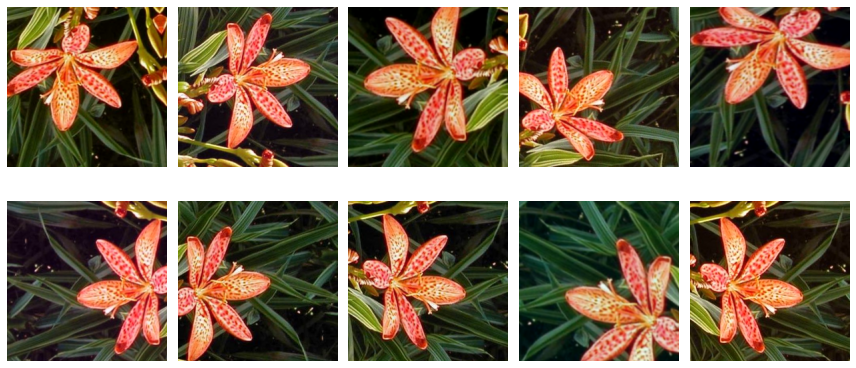

Image shape: (240, 240, 3)


In [25]:
random.seed(42)
figure = visualize_augmentations(train_dataset)
# run['augmentations-example'].upload(figure)

### Обучение модели

In [26]:
# Класс для подсчета метрик во время обучения
class MetricCalculator():
    def __init__(self, float_precision=3):
        self.gloat_precision = float_precision
        self.reset()
        
    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})
        
    def update(self, metric_name, val):
        metric = self.metrics[metric_name]
        metric['val'] += val
        metric['count'] += 1
        metric['avg'] = metric['val']/metric['count']
        
def calculate_accuracy(output, target):
    _, pred_classes = torch.max(output, dim=1)
    correct_pred = (pred_classes == target).float()
    acc = correct_pred.sum()/ len(correct_pred)
    acc = torch.round(acc*100)
    
    return acc.item()

In [27]:
# Загружаем модель
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained(params['model'])

Loaded pretrained weights for efficientnet-b1


In [28]:
# Делаем все параметры модели доступными для обучения
for param in model.parameters():
    param.requires_grad = True

In [29]:
# Меняем FC слой под текущую задачу
features = model._fc.in_features
# out_features = len(labels_mapping['class'].unique())
out_features = len(data_annot_df['class'].unique()) 
print(f'Out features size: {out_features}')
model._fc = nn.Linear(in_features=features, out_features=out_features, bias=True)
# print(model)

Out features size: 102


In [31]:
# Load model
# model = torch.load(os.path.join('models', 'model_flowers_enb1_balanced_train_1_ep7'))

In [32]:
# переносим расчет в ГПУ
if cuda.is_available():
    print('Cuda is available.')
else:
    raise Exception('Cuda is not available')
    
model = model.to(params['device'])
    
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cuda is available.


In [33]:
# Устанавливаем параметры оптимизатора
if params['optimizer'] == 'adam':
    # optimizer Adam (adaptive learning rate, converges faster, final acc could be worse)
    optimizer = optim.Adam(model.parameters())
elif params['optimizer'] == 'sgd':
#     optimizer SGD (sometimes better)
    optimizer = optim.SGD(model.parameters(), lr=0.1)
else:
    raise Exception('Unknown optimizer')

# Устанавливаем параметры диспетчера скорости обучения
if params['use_lr_scheduler']:
    # lr scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=params['exp_lr_gamma'])
    lrs = []

# Устанавливаем параметры функции потерь
if params['criterion'] == 'crossentropyloss':
    # loss function for multiclass
    # loss_func = nn.CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss().to(params['device'])
else:
    raise Exception('Unknown criterion')

In [34]:
# cuda.empty_cache()

In [40]:
# Обучение модели
start_epoch = 7
for epoch in range(1):  
    # Шаг обучения
    # Создание экземляра счетчика метрик
    metric_calc = MetricCalculator()
    
    # Переключаем модели в режим обучения
    model.train()
    
    # Итератор по датасету будет пачками грузить данные согласно параметрам настройки загрузчика
    for ii, (data, target) in enumerate(tqdm(train_loader)):
       
        # Перенос данных в ГПУ
        data = data.to(params['device'], non_blocking=True)
        target = target.to(params['device'], non_blocking=True)        

        # прямой проход
        output = model(data)
        
        # расчет потерь
        loss = criterion(output, target)
        
        # обнуление градиентов оптимизатора (все необходимое будет аккумулировано при обратном проходе)
        optimizer.zero_grad()
        
        # Обратный проход, расчет градиента потерь, аккумулирование для каждого параметра
        loss.backward()

        # Обновление параметров
        optimizer.step()
        
        # Расчет точности в пачке
        accuracy = calculate_accuracy(output, target)
        
        # Расчет усредненной точности в текущй эпохе
        metric_calc.update('epoch/loss', loss.item())
        metric_calc.update('epoch/accuracy', accuracy)
        
            
        # Логирование
        run['train batch/loss'].log(loss.item())
        run['train epoch/cumm loss'].log(metric_calc.metrics['epoch/loss']['avg'])
        run['train epoch/cumm acc'].log(metric_calc.metrics['epoch/accuracy']['avg'])
        
    run['train epoch/acc'].log(metric_calc.metrics['epoch/accuracy']['avg'])
        
    # Шаг валидации
    metric_calc = MetricCalculator()
    model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(tqdm(val_loader)):
            data = data.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(data)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)
            
            metric_calc.update('epoch/loss', loss.item())
            metric_calc.update('epoch/accuracy', accuracy)
            
            # Логирование
            run['val batch/loss'].log(loss.item())
            run['val epoch/cumm loss'].log(metric_calc.metrics['epoch/loss']['avg'])
            run['val epoch/cumm acc'].log(metric_calc.metrics['epoch/accuracy']['avg'])
        
    run['val epoch/acc'].log(metric_calc.metrics['epoch/accuracy']['avg'])
    
    if params['use_lr_scheduler']:
        run['epoch/lr'].log(optimizer.param_groups[0]["lr"])
        scheduler.step()
       
    print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, loss.item()))
    torch.save(model, os.path.join(
        'models', f'model_flowers_enb1_balanced_train_1_ep{start_epoch +epoch+1}'
    ))

100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:30<00:00,  3.97it/s]


Epoch: 1 - Loss: 0.251778


In [97]:
# Сохранение модели
# torch.save(model, os.path.join('models', 'model_flowers_enb2_balanced_train_3_ep1'))

In [23]:
# Остановка логирования
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!


In [35]:
# Расчет прогноза на тестовой выборке
test_predictions = []
outputs = []
model.eval()
with torch.no_grad(): # no need grad calc as no ned in backwards() -> less memory consumption
    for i, (data, target) in enumerate(tqdm(test_loader)):
        data = data.to(params['device'], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(data)
        outputs.append(output)
        _, pred_classes = torch.max(output, dim=1)
        test_predictions.append(pred_classes.cpu().numpy())
        
test_predictions = np.concatenate(test_predictions).tolist()

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:20<00:00,  1.51it/s]


In [38]:
# Расчет и логирование точности на тестовой выборке
def acc(pred, y):
    return sum([int(y_pred == y_true) for y_pred, y_true in zip(pred, y)])/len(pred)
test_accuracy = acc(test_predictions, test_data['class'].values)
print(f'Test accuracy: {test_accuracy}')
run['test accuracy'].log(test_accuracy)

Test accuracy: 0.9715447154471545


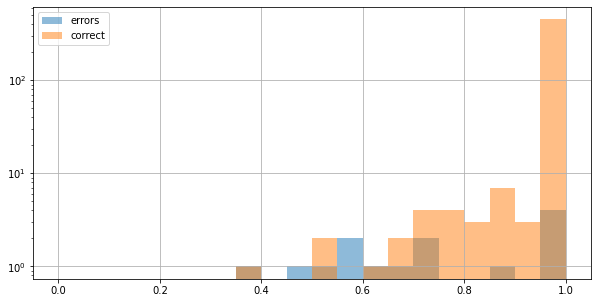

In [39]:
# Распределение кол-ва прогнозов в зависимости от вероятности
probs= []
outputs_t = torch.cat(outputs)
for i, idx in enumerate(torch.topk(outputs_t, k=3).indices.squeeze(0).tolist()):
            prob = torch.softmax(outputs_t, dim=1)[i, idx][0].item()
            probs.append(prob)
            
res_df = pd.DataFrame({
    'pred_y':test_predictions,
    'true_y': test_data['class'].values,
    'prob': probs
})

fig, ax = plt.subplots(figsize=(10, 5))
bins_false = ax.hist(res_df[res_df['pred_y']!=res_df['true_y']]['prob'], alpha=0.5, 
                     bins=[0.05*x for x in range(21)], label='errors')

bins_true = ax.hist(res_df[res_df['pred_y']==res_df['true_y']]['prob'], alpha=0.5, 
                    bins=[0.05*x for x in range(21)], label='correct')
ax.grid()
plt.legend()
plt.yscale('log')
plt.show()

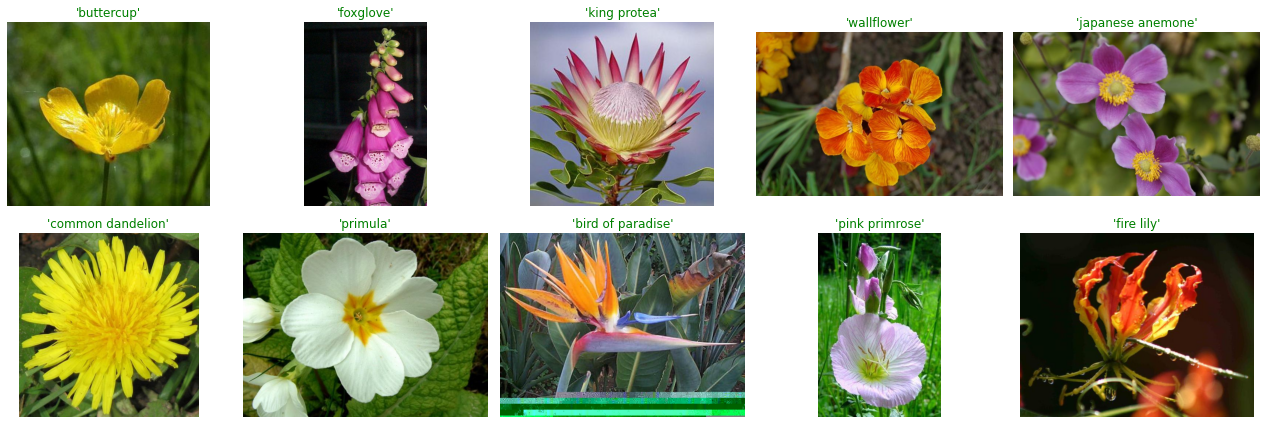

In [40]:
# Визуализаци (части) прогнозов на тестовой выборке
data_to_display = test_data.copy()
data_to_display['pred'] = test_predictions

data_to_display = data_to_display.iloc[:10]
figure = display_image_grid(
    [os.path.join(data_folder, fn) for fn in data_to_display['fname'].values],
    data_to_display['class'].values,
    predicted_labels=data_to_display['pred'].values,
    label_mapping=label_mapping
)

In [67]:
# Функция прогнозирования (все в одном)
def predict(model, image_names, image_dir):
    image_df = pd.DataFrame([
        [image_name, 0] for image_name in image_names
    ], columns=['fname', 'class'])
    pred_ds = FlowersDataset(df=image_df, 
                            data_dir = image_dir,
                            transform=test_transform)
    single_loader = DataLoader(
        dataset = pred_ds, 
        batch_size = params['eval_batch_size'],
        num_workers=params['num_workers'],
        pin_memory=params['pin_memory']
    )
    
    
    predict = []
    outputs = []
    model.eval()
    with torch.no_grad(): # no need grad calc as no ned in backwards() -> less memory consumption
        for i, (data, target) in enumerate(tqdm(single_loader)):
            data = data.to(params['device'], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(data)
            outputs.append(output)
            _, pred_classes = torch.max(output, dim=1)
            predict.extend(pred_classes.cpu().numpy())
    
    outputs = torch.cat(outputs)
    probs = []
    if len(outputs)> 1:
        for i, idx in enumerate(torch.topk(outputs, k=3).indices.squeeze(0).tolist()):
            prob = torch.softmax(outputs, dim=1)[i, idx][0].item()
            probs.append(prob)
    elif len(outputs) == 1:
        top_idxs = torch.topk(outputs, k=3).indices.squeeze(0).tolist()
        prob = torch.softmax(outputs, dim=1)[i, top_idxs][0].item()
        probs.append(prob)
    else:
        raise Exception('No predictions!')
            
    return predict

def decode_class(classes, label_mapping):
    return [label_mapping['label'][cls] for cls in classes]

In [63]:
# Фцнкция прогнозирования
def get_prediction(model, image):
    tensor = test_transform(image=image)['image'].unsqueeze(0)
    tensor = tensor.to(para, non_blocking=True)
    outputs = model(tensor)
    
    _, y_hat = outputs.max(1)
    prob = torch.softmax(outputs, dim=1)[0, y_hat.item()].item()
    predicted_idx = y_hat.item()
    
    return predicted_idx, prob

In [64]:
# img_path = os.path.join('flowers_prod', 'sun.jpg')
# image = cv2.imread(img_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# get_prediction(model, image)

In [65]:
# preds, probs = predict(model, 'narciss.jpg', 'flowers_prod')
# labelled_preds = decode_class(preds, label_mapping)
# print(preds, probs)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.32it/s]


<AxesSubplot:>

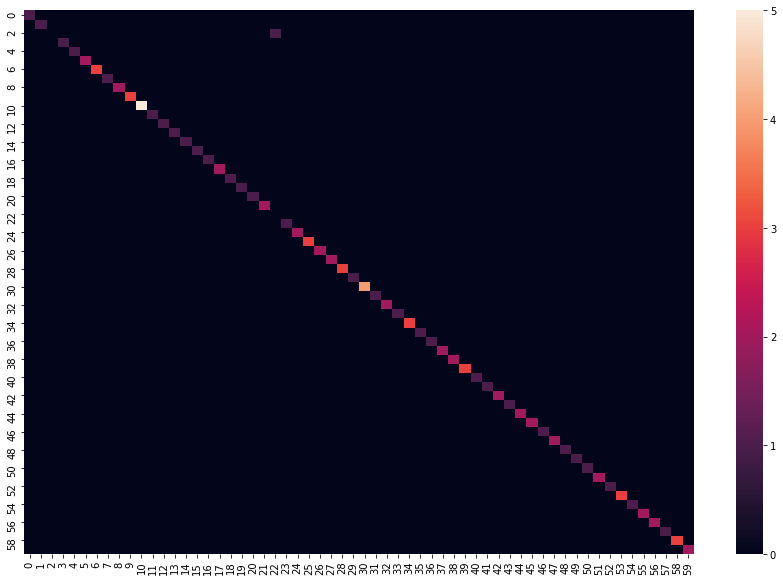

In [70]:
# Матрица ошибок для обучающей выборки
sample_size = 100
train_preds = predict(model, train_data['fname'].values[:sample_size], 'jpg')
cfs = confusion_matrix(list(train_data['class'].values[:sample_size]), train_preds)
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(cfs, ax=ax)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.31it/s]


<AxesSubplot:>

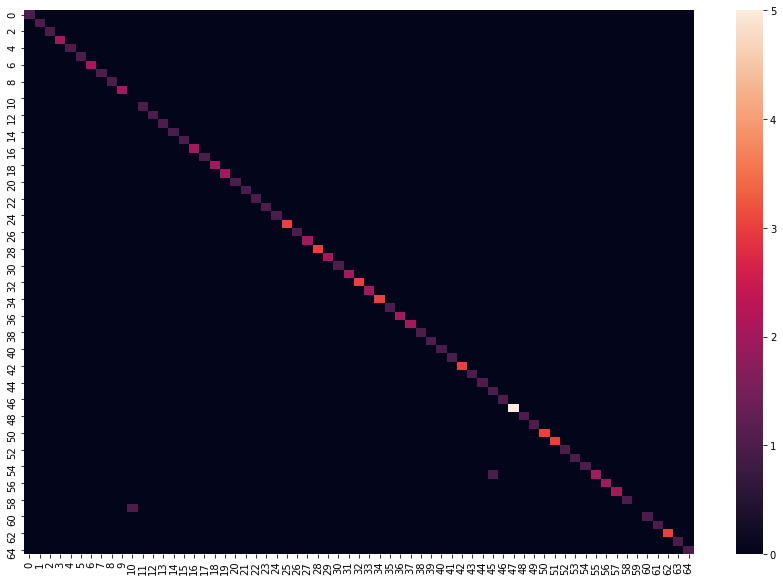

In [71]:
# Матрица ошибок для тестовой выборки
sample_size = 100
test_preds = predict(model, test_data['fname'].values[:sample_size], 'jpg')
cfs_test = confusion_matrix(list(test_data['class'].values[:sample_size]), test_preds)
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(cfs_test, ax=ax)